In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [74]:
# Load the CSV file into a DataFrame
df = pd.read_csv('EVChargingStationUsage.csv',low_memory=False)

In [75]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 0] # Check for missing values (We have a lot)

County                             84665
EVSE ID                            78948
System S/N                         78948
Model Number                       78948
Driver Postal Code                  8402
User ID                             7677
Currency                            1788
Ended By                             248
Transaction Date (Pacific Time)      209
Port Type                              9
dtype: int64

In [76]:
# US county:
# https://www.getzips.com/zip.htm -- determine the county of the zip code, however there is overlap in 94303, Thus: df[df['Postal Code']==94303]['Address 1'].unique()
# From https://geocoding.geo.census.gov/geocoder/geographies
# 3700 Middlefield Rd = Santa Clara
# 1213 Newell Rd = Santa Clara
# 1514 Walnut Dr = Santa Clara
# 1520 Walnut Dr = Santa Clara
# Therefore all of 94303 is in Santa Clara County so all the NaN values can be filled in with Santa Clara

In [77]:
# This cleans up the data a bit
df['Org Name'] = df['Org Name'].unique()[0] # There are multiple values in this column, but they are all the same with a space as the only difference
df['MAC Address'] = df['MAC Address'].str.replace(':', '') # Clean up the MAC Address
df['Station Name'] = df['Station Name'].str.replace('PALO ALTO CA / ', '').str.replace('#','').str.replace('  ',' ').str.replace(' ','_') # Clean up the Station Name
df['Total Duration (m)'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)']).dt.total_seconds()/60 # Convert the time to minutes
df['Charging Time (m)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)']).dt.total_seconds()/60 # Convert the time to minutes
df.drop(columns=['Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)'], inplace=True) # Drop the old columns
df['Port Type'] = df['Port Type'].fillna("Level " + df['Port Number'].astype(str)) # Fill in the missing values in Port Type with the value in Port Number
df['Currency'] = df['Currency'].fillna('Unknown') # Fill in the missing values in Currency with Unknown (ASSUMPTIONS!)
df['USD'] = df['Currency'] == 'USD' # Create a boolean column for USD
df['Ended By'] = df['Ended By'].fillna('Unknown') # Fill in the missing values in Ended By with Unknown (ASSUMPTIONS!)
df['County'] = df['County'].fillna('Santa Clara County') # Fill in the missing values in County with Santa Clara County (Based on the zip and address)
df['Start Date'] = pd.to_datetime(df['Start Date']) # Convert the Start Date to a datetime object
df['End Date'] = pd.to_datetime(df['End Date'],errors='coerce') # Convert the End Date to a datetime object
df['Transaction Date (Pacific Time)'] = pd.to_datetime(df['Transaction Date (Pacific Time)'],errors='coerce').fillna(df['End Date']) # Convert the Transaction Date to a datetime object and fill in the missing values with the End Date (ASSUMPIONS!)

In [78]:
df['Transaction Time (h)'] = df['Transaction Date (Pacific Time)'].dt.hour
df['Day of Week'] = df['Transaction Date (Pacific Time)'].dt.dayofweek
df['Day of Month'] = df['Transaction Date (Pacific Time)'].dt.day
df['Day of Year'] = df['Transaction Date (Pacific Time)'].dt.dayofyear
df['Year'] = df['Transaction Date (Pacific Time)'].dt.year
df['Start Date (h)'] = df['Start Date'].dt.hour
df['End Date (h)'] = df['End Date'].dt.hour

In [79]:
# Drop NA values for invalid Dates (ASSUMPTIONS!)
df.dropna(subset=['Start Date', 'End Date', 'Transaction Date (Pacific Time)'], inplace=True)

In [80]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum() > 0] # Check for missing values (We have a lot)

Model Number          78948
EVSE ID               78948
System S/N            78948
Driver Postal Code     8400
User ID                7675
dtype: int64

In [81]:
# We Should consider if 1. these columns are useful, 2. if they are useful, fill them with a new value (unknown, etc)
df[df['Model Number'].isna()].isna().sum().sort_values(ascending=False)[df.isna().sum() > 0]

Model Number          78948
EVSE ID               78948
System S/N            78948
Driver Postal Code     3191
User ID                2599
dtype: int64

In [82]:
df.columns # Check the columns to see what we have to work with

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number', 'Total Duration (m)', 'Charging Time (m)',
       'USD', 'Transaction Time (h)', 'Day of Week', 'Day of Month',
       'Day of Year', 'Year', 'Start Date (h)', 'End Date (h)'],
      dtype='object')

In [83]:
df.nunique().sort_values(ascending=False) # Check the amount of unique values in each column

Start Date                         244762
End Date                           244119
Transaction Date (Pacific Time)    241042
Energy (kWh)                       118061
Plug In Event Id                    36836
Total Duration (m)                  31024
Charging Time (m)                   22473
User ID                             21440
GHG Savings (kg)                    15535
Gasoline Savings (gallons)           6333
Fee                                  1817
Driver Postal Code                    984
Day of Year                           366
System S/N                             81
MAC Address                            68
Longitude                              64
Latitude                               62
EVSE ID                                51
Station Name                           46
Day of Month                           31
End Date (h)                           24
Transaction Time (h)                   24
Start Date (h)                         24
Address 1                         

There are a lot of unique values in the categorical sense, so it might be prudent to figure out what values to work with. Here is an initial list of suggestions
* Energy (kWh)
* Port Type
* Plug Type
* Postal Code (to indicate spatial location)
* Currency (Perhaps binary conversion USD/Not USD)
* Total Duration (m)
* Charging Time (m)
* Hour of Day
* Day of Week
* ?Maybe driver zipcode (There are over 900 and they are categorical)?

Potential for interesting insights:
* Model Number
* Ended By
* Fee
* Driver Postal Code
* Month

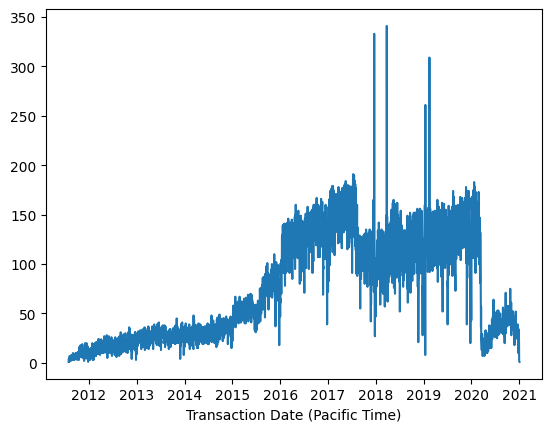

In [104]:
df['Transaction Date (Pacific Time)'].dt.date.value_counts().sort_index().plot() # Plot the number of transactions per day
df['Date'] = df['Transaction Date (Pacific Time)'].dt.date # Create a new column with just the date

In [96]:
df_working = df[['Date', 'Transaction Time (h)', 'Port Type', 'Plug Type', 'Charging Time (m)', 'Energy (kWh)', 'Total Duration (m)', 'USD', 'Postal Code']] # Select the columns we want to work with

In [97]:
df_working = pd.get_dummies(df_working, columns=['Port Type', 'Plug Type', 'Postal Code']) # One hot encode the data

# Predictive Model

In [98]:
# Train test split, 70% training, 30% testing
X_train, X_test = df_working[:int(len(df)*0.7)], df_working[int(len(df)*0.7):]
y_train, y_test = X_train.pop('Energy (kWh)'), X_test.pop('Energy (kWh)')

In [99]:
df_working

,Date,Transaction Time (h),Charging Time (m),Energy (kWh),Total Duration (m),Day of Week,USD,Port Type_Level 1,Port Type_Level 2,Plug Type_J1772,Plug Type_NEMA 5-20R,Postal Code_94301,Postal Code_94303,Postal Code_94306
0,2011-07-29,23.0,114.050000,6.249457,183.533333,4.0,True,False,True,True,False,True,False,False
1,2011-07-30,0.0,1.900000,0.106588,2.100000,5.0,True,False,True,True,False,True,False,False
2,2011-07-30,12.0,257.466667,14.951777,257.533333,5.0,True,False,True,True,False,True,False,False
3,2011-07-30,16.0,122.966667,7.159643,123.400000,5.0,True,False,True,True,False,True,False,False
4,2011-07-30,20.0,43.900000,1.957765,71.400000,5.0,True,False,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259410,2020-12-31,17.0,35.300000,1.841000,35.733333,3.0,True,False,True,True,False,False,False,True
259411,2020-12-31,20.0,134.066667,12.744000,223.016667,3.0,True,False,True,True,False,True,False,False
259412,2021-01-01,10.0,308.200000,29.665000,1048.233333,4.0,True,False,True,True,False,False,True,False
259413,2020-12-31,21.0,233.700000,11.976000,245.566667,3.0,True,False,True,True,False,True,False,False


Baseline model score: 1041.9208247755075
Linear Regression model score: -60.020954930770856


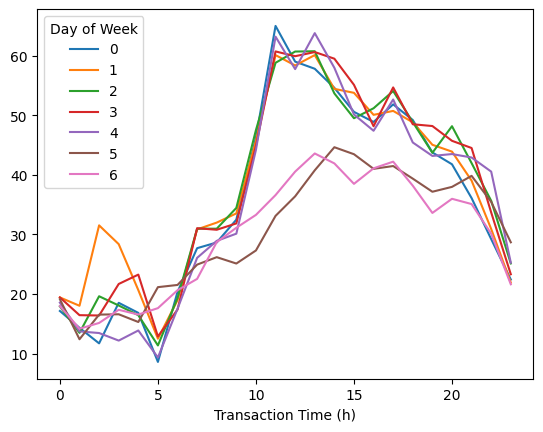

In [157]:
# Takes the sum of for each date and transaction time so multiple charging events are combined
# Then takes the average energy usage per hour of the day
# Then creates a new column with the average energy usage per hour of the day
# Then merges the new column with the original DataFrame
# Then calculates the mean squared error of the baseline model

df_test = df_working.groupby(['Date','Transaction Time (h)']).sum().reset_index()
df_test['Day of Week'] = pd.to_datetime(df_test['Date']).dt.dayofweek
df_test[:int(len(df)*0.7)].groupby(['Transaction Time (h)', 'Day of Week'])['Energy (kWh)'].mean().unstack().plot() # Plot the average energy usage per hour of the day

y_pred = df_test[:int(len(df)*0.7)].groupby(['Transaction Time (h)', 'Day of Week'])['Energy (kWh)'].mean().reset_index()

df_test = df_test.merge(y_pred, on=['Transaction Time (h)', 'Day of Week'], suffixes=('', '_pred'))

print('Baseline model score:', ((df_test[int(len(df_test)*0.7):]['Energy (kWh)_pred'] - df_test[int(len(df_test)*0.7):]['Energy (kWh)'])**2).mean())

print('Linear Regression model score:', cross_val_score(LinearRegression(), df_test[:int(len(df)*0.7)].drop(columns=['Energy (kWh)','Date']), df_test[:int(len(df)*0.7)]['Energy (kWh)'], cv=5, scoring='neg_mean_squared_error').mean())

In [ ]:
# This is timeseries data, so we should use a timeseries model
# We can use the ARIMA model for this
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_test[:int(len(df)*0.7)].groupby(['Date','Transaction Time (h)'])['Energy (kWh)'].sum(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

